# Initial Analysis

In [1]:
import pandas as pd 

# Load the dataset 
file_path = 'attack_data/datasets/attack_techniques/T1003.001/atomic_red_team/windows-sysmon.log' 

# Read log data from a file
with open(file_path, 'r') as file:
    log_data = file.read()

In [2]:
import xml.etree.ElementTree as ET

# Function to parse the XML log data
def parse_log_data(log_data):
    events = []
    root = ET.fromstring(f"<root>{log_data}</root>")
    ns = {'ns': 'http://schemas.microsoft.com/win/2004/08/events/event'}
    
    for event in root.findall('ns:Event', ns):
        event_data = {}
        system = event.find('ns:System', ns)
        event_data['EventID'] = system.find('ns:EventID', ns).text
        event_data['TimeCreated'] = system.find('ns:TimeCreated', ns).attrib['SystemTime']
        event_data['Computer'] = system.find('ns:Computer', ns).text
        event_data['ProcessID'] = system.find('ns:Execution', ns).attrib['ProcessID']
        event_data['ThreadID'] = system.find('ns:Execution', ns).attrib['ThreadID']

        eventdata = event.find('ns:EventData', ns)
        for data in eventdata.findall('ns:Data', ns):
            event_data[data.attrib['Name']] = data.text
        
        events.append(event_data)
    return events

# Parse the log data
events = parse_log_data(log_data)

# Create DataFrame
df = pd.DataFrame(events)

# Data Cleaning 
data = df.dropna(axis=1, how='all')

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler 

# Define a target variable 
data['target'] = data['SourceImage'] == 'C:\\Windows\\system32\\svchost.exe' 
data['target'] = data['target'].astype(int)

# Convert categorical columns to numeric 
categorical_columns = data.select_dtypes(include=['object']).columns 
label_encoders = {} 
for column in categorical_columns: 
    le = LabelEncoder() 
    data[column] = le.fit_transform(data[column].astype(str)) 
    label_encoders[column] = le

# Standardize the features 
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(data.drop('target', axis=1))

# Convert the scaled data back to a DataFrame 
data_scaled_df = pd.DataFrame(data_scaled, columns=data.drop('target', axis=1).columns) 
data_scaled_df['target'] = data['target']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Split the data into training and testing sets 
X = data_scaled_df.drop('target', axis=1) 
y = data_scaled_df['target'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Feature Importance

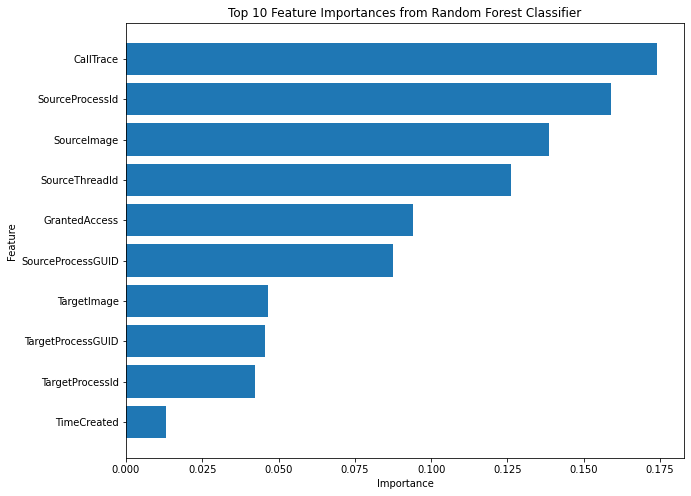

              Feature  Importance
15          CallTrace    0.174118
8     SourceProcessId    0.158836
10        SourceImage    0.138490
9      SourceThreadId    0.126264
14      GrantedAccess    0.094165
7   SourceProcessGUID    0.087515
13        TargetImage    0.046608
11  TargetProcessGUID    0.045638
12    TargetProcessId    0.042223
1         TimeCreated    0.013108


In [5]:
# Train a Random Forest classifier 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0) 
rf_classifier.fit(X_train, y_train) 

# Get feature importances 
feature_importances = rf_classifier.feature_importances_ 
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}) 
importance_df = importance_df.sort_values(by='Importance', ascending=False) 

# Select top 10 features 
top_10_features = importance_df.head(10) 

# Display the top 10 feature importances 
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances from Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

print(top_10_features)

# Logistic Regression

Logistic Regression Accuracy: 0.9239949748743719


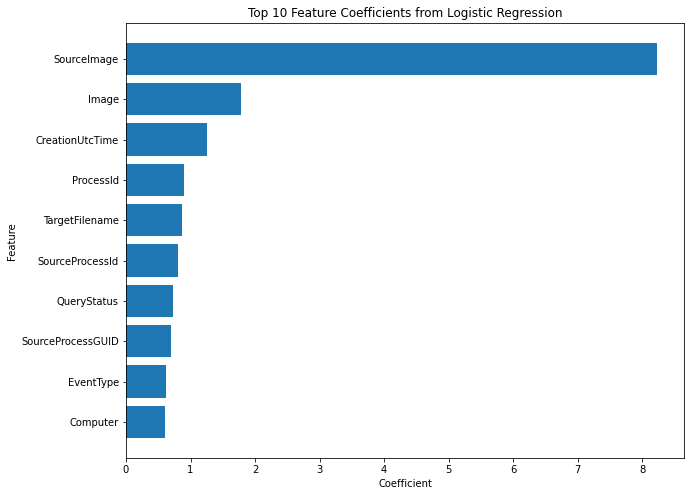

              Feature  Coefficient
10        SourceImage     8.232161
18              Image     1.781896
42    CreationUtcTime     1.248140
17          ProcessId     0.896331
41     TargetFilename     0.874906
8     SourceProcessId     0.813506
47        QueryStatus     0.723836
7   SourceProcessGUID     0.702281
43          EventType     0.624043
2            Computer     0.607526


In [6]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=0)
log_reg.fit(X_train, y_train)

# Evaluate the model
accuracy = log_reg.score(X_test, y_test)
print(f'Logistic Regression Accuracy: {accuracy}')

# Get the coefficients (feature importances)
coefficients = log_reg.coef_[0]
importance_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

# Select top 10 features
top_10_features = importance_df.head(10)

# Display the top 10 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature'], top_10_features['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 10 Feature Coefficients from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

print(top_10_features)

Confusion Matrix:
[[623  66]
 [ 55 848]]


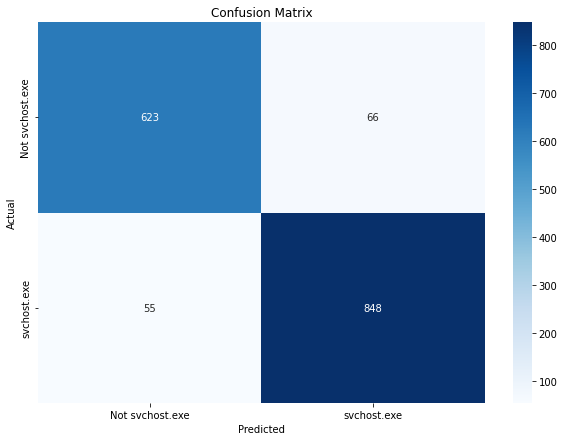


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       689
           1       0.93      0.94      0.93       903

    accuracy                           0.92      1592
   macro avg       0.92      0.92      0.92      1592
weighted avg       0.92      0.92      0.92      1592


ROC AUC Score:
0.9216504571923616


In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score 
import seaborn as sns 

# Predict the test set results 
y_pred = log_reg.predict(X_test)

# Confusion Matrix  
print("Confusion Matrix:") 
conf_matrix = confusion_matrix(y_test, y_pred) 
print(conf_matrix) 

# Plot Confusion Matrix 
plt.figure(figsize=(10, 7)) 
sns.heatmap(
conf_matrix, 
annot=True, 
fmt='d', 
cmap='Blues', 
xticklabels=['Not svchost.exe', 'svchost.exe'], 
yticklabels=['Not svchost.exe', 'svchost.exe']
)
plt.title("Confusion Matrix") 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
plt.show()

# Evaluation
print("\nClassification Report:") 
print(classification_report(y_test, y_pred)) 
print("\nROC AUC Score:") 
print(roc_auc_score(y_test, y_pred))

# Anomaly Detection

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of anomalies detected: 796
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.3862857142857143
Confusion Matrix:
[[2704  796]
 [4460    0]]


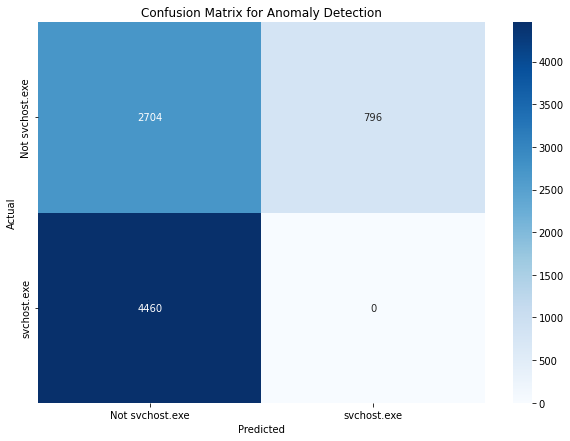

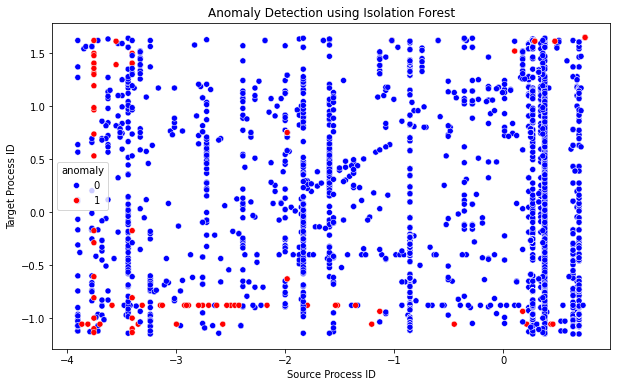

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize and train the Isolation Forest model 
iso_forest = IsolationForest(contamination=0.1, random_state=0) 
iso_forest.fit(data_scaled_df.drop(columns=['target'])) 

# Predict anomalies 
data_scaled_df['anomaly'] = iso_forest.predict(data_scaled_df.drop(columns=['target'])) 

# -1 for anomalies, 1 for normal points 
data_scaled_df['anomaly'] = data_scaled_df['anomaly'].map({1: 0, -1: 1}) 

# Count anomalies 
num_anomalies = data_scaled_df['anomaly'].sum() 
print(f"Number of anomalies detected: {num_anomalies}") 

# Evaluate the anomaly detection performance
precision = precision_score(data_scaled_df['target'], data_scaled_df['anomaly'])
recall = recall_score(data_scaled_df['target'], data_scaled_df['anomaly'])
f1 = f1_score(data_scaled_df['target'], data_scaled_df['anomaly'])
roc_auc = roc_auc_score(data_scaled_df['target'], data_scaled_df['anomaly'])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Confusion Matrix 
print("Confusion Matrix:") 
conf_matrix = confusion_matrix(data_scaled_df['target'], data_scaled_df['anomaly']) 
print(conf_matrix) 

# Plot Confusion Matrix 
plt.figure(figsize=(10, 7)) 
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Not svchost.exe', 'svchost.exe'], 
    yticklabels=['Not svchost.exe', 'svchost.exe']
)
plt.title("Confusion Matrix for Anomaly Detection") 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
plt.show()

# Visualize anomalies 
plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=data_scaled_df, x='SourceProcessId', y='TargetProcessId', hue='anomaly', palette={0: 'blue', 1: 'red'}) 
plt.title('Anomaly Detection using Isolation Forest') 
plt.xlabel('Source Process ID') 
plt.ylabel('Target Process ID') 
plt.show() 



In [9]:
# Add additional features if possible
# Here are some ideas:
# - Calculate time differences between events
# - Aggregate counts of events per process

# Example: Adding a feature for the time difference between events
data_scaled_df['TimeCreated'] = pd.to_datetime(data_scaled_df['TimeCreated'])
data_scaled_df = data_scaled_df.sort_values(by='TimeCreated')
data_scaled_df['TimeDiff'] = data_scaled_df['TimeCreated'].diff().dt.total_seconds().fillna(0)

# Remove the 'TimeCreated' column after creating 'TimeDiff'
features = data_scaled_df.drop(['target', 'anomaly', 'TimeCreated'], axis=1)

# Standardize the new feature
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features['target'] = data_scaled_df['target']
features['anomaly'] = data_scaled_df['anomaly']


Number of anomalies detected by One-Class SVM: 796
One-Class SVM Precision: 0.5201005025125628
One-Class SVM Recall: 0.09282511210762331
One-Class SVM F1 Score: 0.15753424657534246
One-Class SVM ROC AUC Score: 0.4918411274823831
Confusion Matrix for One-Class SVM:
[[3118  382]
 [4046  414]]


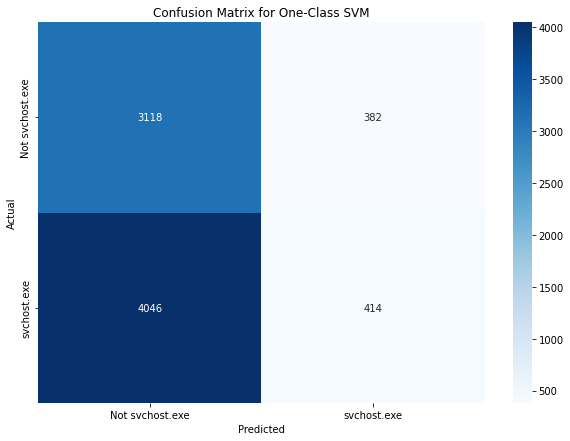

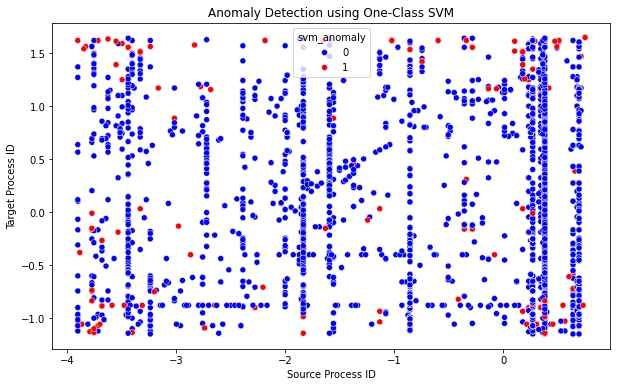

In [10]:
from sklearn.svm import OneClassSVM

# Initialize and train the One-Class SVM model
oc_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
oc_svm.fit(features.drop(columns=['target', 'anomaly']))

# Predict anomalies
features['svm_anomaly'] = oc_svm.predict(features.drop(columns=['target', 'anomaly']))

# -1 for anomalies, 1 for normal points (One-Class SVM uses 1 for normal and -1 for anomalies by default)
features['svm_anomaly'] = features['svm_anomaly'].map({1: 0, -1: 1})

# Count anomalies
num_anomalies_svm = features['svm_anomaly'].sum()
print(f"Number of anomalies detected by One-Class SVM: {num_anomalies_svm}")

# Evaluate the anomaly detection performance
precision_svm = precision_score(features['target'], features['svm_anomaly'])
recall_svm = recall_score(features['target'], features['svm_anomaly'])
f1_svm = f1_score(features['target'], features['svm_anomaly'])
roc_auc_svm = roc_auc_score(features['target'], features['svm_anomaly'])

print(f"One-Class SVM Precision: {precision_svm}")
print(f"One-Class SVM Recall: {recall_svm}")
print(f"One-Class SVM F1 Score: {f1_svm}")
print(f"One-Class SVM ROC AUC Score: {roc_auc_svm}")

# Confusion Matrix
print("Confusion Matrix for One-Class SVM:")
conf_matrix_svm = confusion_matrix(features['target'], features['svm_anomaly'])
print(conf_matrix_svm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix_svm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not svchost.exe', 'svchost.exe'],
    yticklabels=['Not svchost.exe', 'svchost.exe']
)
plt.title("Confusion Matrix for One-Class SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='SourceProcessId', y='TargetProcessId', hue='svm_anomaly', palette={0: 'blue', 1: 'red'})
plt.title('Anomaly Detection using One-Class SVM')
plt.xlabel('Source Process ID')
plt.ylabel('Target Process ID')
plt.show()

In [11]:
# from sklearn.svm import OneClassSVM

# # Initialize and train the One-Class SVM model
# oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
# oc_svm.fit(features.drop(['target', 'anomaly'], axis=1))

# # Predict anomalies
# data_scaled_df['anomaly'] = oc_svm.predict(features.drop(['target', 'anomaly'], axis=1))
# data_scaled_df['anomaly'] = data_scaled_df['anomaly'].map({1: 0, -1: 1})

# # Count anomalies
# num_anomalies = data_scaled_df['anomaly'].sum()
# print(f"Number of anomalies detected: {num_anomalies}")

# # Evaluate the model
# print("Confusion Matrix for Anomaly Detection:")
# conf_matrix_anomaly = confusion_matrix(y_anomaly, data_scaled_df['anomaly'])
# print(conf_matrix_anomaly)

# plt.figure(figsize=(10, 7))
# sns.heatmap(
#     conf_matrix_anomaly,
#     annot=True,
#     fmt='d',
#     cmap='Blues',
#     xticklabels=['Normal', 'Anomaly'],
#     yticklabels=['Normal', 'Anomaly']
# )
# plt.title("Confusion Matrix for Anomaly Detection")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

# print("\nClassification Report for Anomaly Detection:")
# print(classification_report(y_anomaly, data_scaled_df['anomaly']))

# print("\nROC AUC Score for Anomaly Detection:")
# print(roc_auc_score(y_anomaly, data_scaled_df['anomaly']))


# Threat Prediction

Gradient Boosting Classifier:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       689
           1       1.00      1.00      1.00       903

    accuracy                           1.00      1592
   macro avg       1.00      1.00      1.00      1592
weighted avg       1.00      1.00      1.00      1592


ROC AUC Score:
1.0
Confusion Matrix - Gradient Boosting Classifier:
[[689   0]
 [  0 903]]


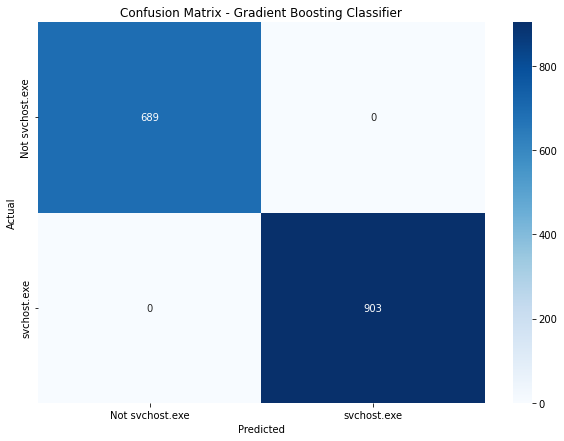

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=0)
gb_classifier.fit(X_train, y_train)

# Predict the test set results
y_pred_gb = gb_classifier.predict(X_test)

# Evaluation of Gradient Boosting Classifier
print("Gradient Boosting Classifier:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_gb))

# Confusion Matrix for Gradient Boosting Classifier
print("Confusion Matrix - Gradient Boosting Classifier:")
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print(conf_matrix_gb)

# Plot Confusion Matrix for Gradient Boosting Classifier
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not svchost.exe', 'svchost.exe'], yticklabels=['Not svchost.exe', 'svchost.exe'])
plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Behavioral Analysis 

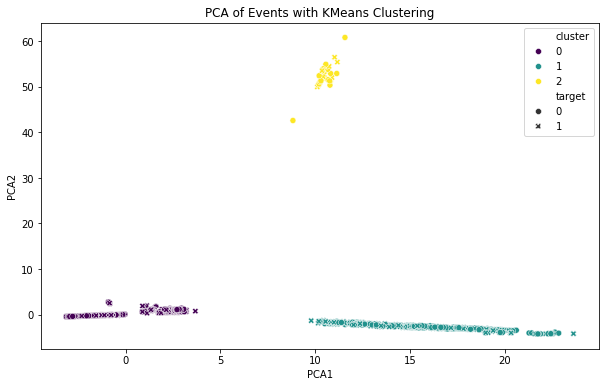

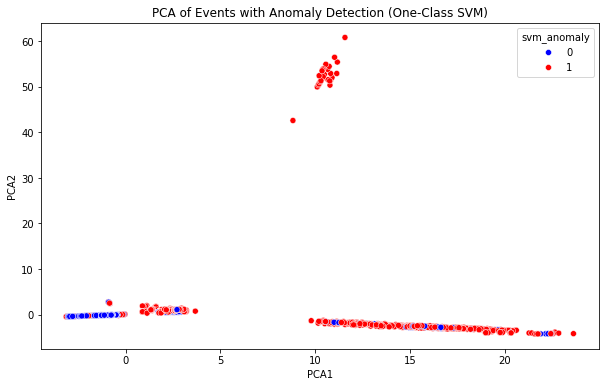

In [13]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

# Standardize the data before applying PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.drop(columns=['target', 'anomaly', 'svm_anomaly']))

# Apply PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2'])
pca_df['target'] = features['target'].values
pca_df['svm_anomaly'] = features['svm_anomaly'].values

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(pca_features)
pca_df['cluster'] = kmeans.labels_

# Visualize the PCA results and KMeans clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis', style='target')
plt.title('PCA of Events with KMeans Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# Visualize the PCA results with anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='svm_anomaly', palette={0: 'blue', 1: 'red'})
plt.title('PCA of Events with Anomaly Detection (One-Class SVM)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

